# Week 04 seminar: Finetuning.

In [1]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch
import torch
import torchvision
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure that output below says `device=device(type='cuda')` - you will need CUDA for faster model runs
# If in Colab, we recommend that you go to Runtime -> Change Runtime Type -> GPU

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='2.0.1+cu118', torchvision.__version__='0.15.2+cu118', device=device(type='cuda'), torch.get_num_threads()=1


In [4]:
import os

def find_path(name, path='/content'):
    '''
    поиск файла или папки
    '''
    result = []
    for root, dirs, files in os.walk(path):
        if name in files+dirs:
          result.append([os.path.join(root, name), root])
    return result

if len(find_path('MyDrive')) == 0 and True:
  from google.colab import drive
  drive.mount('/content/drive')
#os.chdir('/content/drive/My Drive/Colab Notebooks')

In [5]:
os.chdir(find_path('DL_4_finetuning')[0][0])

## TorchVision

[Torchvision](https://pytorch.org/vision/main/index.html) - part of PyTorch library with convenient tools and data for deep learning in visual domain.
- contains a number of popular vision [datasets](https://pytorch.org/vision/stable/datasets.html)
- preprocessing [tools](https://pytorch.org/vision/stable/transforms.html)
- and most importantly, [pre-trained models](https://pytorch.org/vision/main/models.html).

# Datasets: Imagenet

![imagenet_tiles](https://i.imgur.com/n4QIrzF.jpeg)

Today we're going to use and fine-tune CNN based on weights pre-trained on ImageNet.

What is Imagenet?
- large size image classification dataset.
    - ImageNet-1K contains 1,281,167 training images, 50,000 validation images and 100,000 test images.
    - Full original dataset (ImageNet-21k) contains 14,197,122 images divided into 21,841 classes
    - Resolution varies, average resolution: 469x387 pixels
- built pre-2010 by [Fei-Fei Li](https://en.wikipedia.org/wiki/Fei-Fei_Li) at Princeton
- made very popular by ImageNet Large Scale Visual Recognition Challenge (ILSVRC). See AlexNet moment: [chart](https://www.researchgate.net/figure/ImageNet-Competition-Results-50_fig1_329975404), [wiki](https://en.wikipedia.org/wiki/AlexNet), [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
-  still relevant; [accuracy history 2013 to date](https://paperswithcode.com/sota/image-classification-on-imagenet)
- More about Imagenet: http://image-net.org/,  https://en.wikipedia.org/wiki/ImageNet

In [5]:
# loading Imagenet class labels for interpreting classification results
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


# Pretrained models: Resnet


Torchvision models classification models with benchmarks may be viewed [here.](https://pytorch.org/vision/main/models.html#classification)

For this seminar we're going to use Pytorch implementation of popular Resnet model.

In [14]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights
device = 'cuda'
model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False);        # set the model to evaluation mode

In [7]:
# view the model structure. Familiar layers are combined into 4 blocks
# note the last LINEAR layer named 'fc' that converts embeddings of size 512 into logits for 1000 Imagenet classes
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### testing the pretrained model 1
test output dimensions with dummy inputs<br>
note that model inputs have to be 4D: (batch_size, color_channes, height, width)<br>
output is a 2D tensor of logits (batch_size, number_of_classes)

In [7]:
dummy_x = torch.randn(5, 3, 224, 224, device=device)  # dummy batch of 5 'images' sized 224x224 with 3 channels, created on GPU
result = model(dummy_x)
assert result.shape == (5, 1000)   # output is a 2D tensor of logits (batch_size, number_of_classes)

### testing the pretrained model 2. Predict class probabilities.

(224, 224)


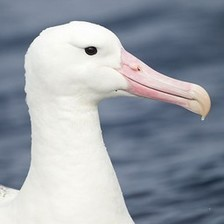

In [8]:
# loading image with PIL library
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alternative source
print(img.size)
img

In [9]:
# converting PIL image to torch.Tensor - detailed process
img_torch = torch.tensor(np.array(img), device=device)  # convert PIL image to np.array, then to torch.Tensor,
img_torch = img_torch.permute(2,0,1)  # reorder channels to move color to the front position, to match pytorch conventions
img_torch = img_torch / img_torch.max()  # scale to 0..1

img_torch.shape, img_torch.device, img_torch.min().item(), img_torch.max().item()  # verify shape, device and range

(torch.Size([3, 224, 224]), device(type='cpu'), 0.007843137718737125, 1.0)

In [10]:
# converting PIL image to torch.Tensor - easy process
# PIL image to torch.Tensor can be converted with torchvision.transforms, equivalent to the above code (more details below)
img_torch = transforms.ToTensor()(img)
img_torch.shape, img_torch.max(), img_torch.min()

(torch.Size([3, 224, 224]), tensor(1.), tensor(0.0078))

In [11]:
# Predicting image class with pretrained model


def predict_img(img, model, top_n=5):
    if isinstance(img, str):
        Image.open(requests.get(url, stream=True).raw).convert('RGB')  # for loading images from url

    img_torch = transforms.ToTensor()(img)  # to torch.Tensor, reorder color channels, s|cale to 0..1
    img_torch = transforms.Resize((224, 224))(img_torch)      # another useful transform to resize images
    img_torch = img_torch.unsqueeze(0)                        # add batch dimension (remember that model needs 4D input)
    img_torch = img_torch.to(device)                          # moving the tensor to device (presumably cuda, in initialized above)
    prediction = model(img_torch)                             # obtain prediction logits from the model
    probs = torch.nn.functional.softmax(prediction, dim=-1)   # convert logits into probabilities
    probs = probs.cpu().data.numpy()                          # convert CUDA tensor to numpy array

    top_ix = probs.ravel().argsort()[-1: -top_n - 1: -1]      # get indices of most probable classes
    print (f'top-{top_n} classes:')                           # look up class label
    for l in top_ix:
        print (f"{probs.ravel()[l]:>6.2%}  {imagenet_labels[l].split(',')[0]}")


predict_img(img, model)

top-5 classes:
98.70%  albatross
 0.46%  spoonbill
 0.39%  American_egret
 0.19%  goose
 0.12%  crane


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### testing the pretrained model 3: Images from unknown classes

Play with imahes from these and other (yours) URLS. Note how object outsize of imagenet classes confuse the net. Low probabilities in top classes are indications of model's low confidence.

(1021, 1282)


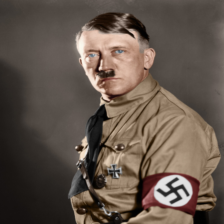

top-5 classes:
10.41%  military_uniform
 9.55%  lab_coat
 5.18%  jersey
 4.22%  sweatshirt
 3.24%  stethoscope


In [12]:
url= 'https://m.media-amazon.com/images/M/MV5BMTMwMmI5NTUtMWFiZi00YjI5LWJhZDQtMTA5MzhkNWNjMmFkXkEyXkFqcGdeQXVyNjUxMjc1OTM@._V1_.jpg'

# <TRY ANY OTHER IMAGES YOU LIKE>

web_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
print(web_img.size)
display(transforms.Resize((224, 224))(web_img))
predict_img(web_img, model)

## More Torchvision tools: Transforms and transform pipelines¶

You already used `transforms.ToTensor` and `transforms.Resize` above. There are many more at [Torchvision](https://pytorch.org/vision/stable/transforms.html). For easier application they are typically combined into pipelines. See examples below.

For more advanced tranforms (faster and compatible with tasks requiring mask or reference points), check out [Albumentations library](https://albumentations.ai/).

In [8]:
from torchvision import transforms

# Typical transform pipeline for test loop
transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Optional: normalize imaged according to ImageNet standards
])

img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alt link
img_torch = transform_pipeline(img)

print(type(img_torch), img_torch.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


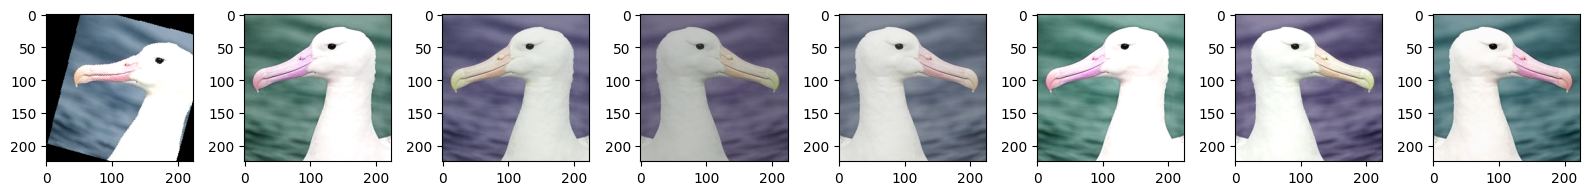

In [14]:
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg')  # alternative source

# Demo of augmentations for train pipeline

transform_pipeline_2 = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),  # not always applicable
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Optional: normalizes imaged according to ImageNet standards
])

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_2 = transform_pipeline_2(img)
    ax.imshow(img_2.permute(1, 2, 0))
plt.tight_layout()

# Classifying with CNN model's latent features
Pretrained image classification models learn extract image features that are useful in classification tasks. We need to get those features from outputs of the model's penultimate level and pass them to classifier.
While this is not exactly a proper finetuning, this method is quick, rather robust and allows to classify unknown classes using quite small training sets (tens / hundreds of images).

### How to get features
features = activations before the very last Linear layer of the model (named `fc` in Resnet - check the model structure above.

During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [15]:
class Identity(torch.nn.Module):
    """replacement for the last model layer to deliver the unaltered inputs of the last layer"""

    def forward(self, x):
        return x

# it is practically same as torch.nn.Identity() - check https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Identity

In [16]:
# Create model clone with altered last layer
embedding_model = deepcopy(model)  # start with a clone of the original model
embedding_model.fc = Identity()    # redefine the last layer to be Identity|
embedding_model = embedding_model.to(device)  # move the result to CUDA

In [17]:
img = Image.open(requests.get('https://i.imgur.com/6CkG5KL.jpeg', stream=True).raw)
# img = Image.open('sample_images/albatross.jpg') # alt link
img_torch = transforms.ToTensor()(img).unsqueeze(0).to(device)
out = embedding_model(img_torch).cpu().data.numpy()
assert out.shape == (1, 512), "your output for single image should have shape (1, 512)"

# Starter problem: cat-dog classification
Your next task is to use a pre-trained model to distinguish between cats and dogs.
- viewed as imposible in 2000
- popular data science challenge problem in 2010
- warm-up task for students in 2020s <br>
![cat_meme](https://i.imgur.com/u1bubWv.jpeg)

In [19]:
# download the dataset
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O dogs_vs_cats_1000.zip

--2023-10-15 13:14:22--  https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46394659 (44M) [application/zip]
Saving to: ‘dogs_vs_cats_1000.zip’

dogs_vs_cats_1000.z 100%[===================>]  44.25M  19.5MB/s    in 2.3s    

2023-10-15 13:14:26 (19.5 MB/s) - ‘dogs_vs_cats_1000.zip’ saved [46394659/46394659]



In [20]:
!unzip -qn dogs_vs_cats_1000.zip
!ls dogs_vs_cats_1000 | wc -l  # should be 2000 images extracted

2000


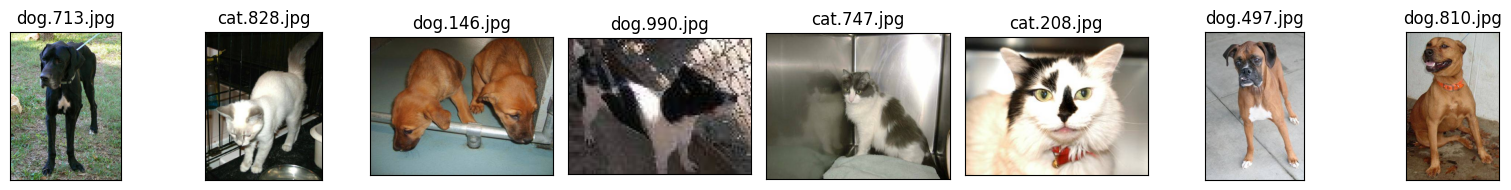

In [21]:
# Sample pets images
import random
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

fnames = [fn for fn in os.listdir('dogs_vs_cats_1000')]
for ax, fname in zip(axs.ravel(), random.choices(fnames, k=8)):
    img_ = Image.open(os.path.join('dogs_vs_cats_1000', fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [26]:
# Here we generate image embeddings using the activations before the last layer
# use batches to accelerate the process

X_ = []  # storage for batches embeddings
Y_ = []  # storage for batches labels

filenames = [fname for fname in os.listdir('dogs_vs_cats_1000')]
batch_size = 64
x_batch_list = []  # to accumulate batch components

with torch.no_grad():
    for i, fname in enumerate(tqdm(filenames)):
        img = Image.open(os.path.join("dogs_vs_cats_1000", fname))
        img_torch = transforms.ToTensor()(img.resize((224, 224)))
        x_batch_list.append(img_torch)
        Y_.append(1 if fname.startswith("cat") else 0)

        if len(x_batch_list) == batch_size or i >= len(filenames) - 1:
            x_batch = torch.stack(x_batch_list)
            # use your embedding model to produce embeddings vectors, convert result to numpy array
            embeddings = embedding_model(x_batch).cpu().data

            assert isinstance(embeddings,  torch.Tensor)
            assert embeddings.ndim == 2 and embeddings.shape[1] == 512
            X_.append(embeddings)
            x_batch_list = []

  0%|          | 0/2000 [00:00<?, ?it/s]

In [27]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array.
Y = np.array(Y_[:len(X)])  # convert labels into np array; crop if we ended prematurely

print(X.shape, Y.shape, np.mean(Y))

assert X.ndim == 2 and X.shape[1] == 512
assert X.shape[0] == len(filenames)
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.49 <= np.mean(Y) <= 0.51

(2000, 512) (2000,) 0.5


### embeddings classification with ML-1 tools

In [28]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

* Train sklearn model, evaluate validation accuracy (should be >90%)

__Task 1 (2 points)__:<br>  
- write the code for cats/dogs classification using the embeddings created above. Use any classification tools that you learned. Reach at least 95% accuracy. __(1 point)__.  Try few different tools if accuracy is not high enough. <br>
(You may choose any classifier algorithm as long as it gets above 95% accuracy. To get the max grade here, you need to tune main hyperparameters of your chosen algorithm (e.g. k for KNN, tree depth, logreg C) depending on how many data points you have. )
- try this excercise with much smaller training set. Find the lowest train set size that you can at which you can still predict cat/dog class with 95% accuracy __(1 point)__ <br>
(note: exact threshold may depend on algorightm choice and train/test split. Show your effort in  experimenting with low train set sizes.)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

print(f'Percent of dogs: {int(Y_train.sum()*100/Y_train.shape[0])}%')
#<YOUR CODE HERE>
#Y_pred = ... <ALSO YOUR CODE>
#print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")

Percent of dogs: 50%


#### Logistic regression


In [116]:
%%time
from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import GridSearchCV, StratifiedKFold

logistic_Reg = linear_model.LogisticRegression(random_state=42, max_iter=200)

# greed search for finding optimal hyperparameter
parameters = {"C": (0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#lr- our logistic  regression, skf- stratified кросс валидационный генератор
grid_searcher_lin_reg = GridSearchCV(estimator=logistic_Reg, cv=skf, param_grid=parameters, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_searcher_lin_reg.fit(X_train, Y_train)
our_best_find_param_lin_reg = grid_searcher_lin_reg.best_params_
grid_searcher_lin_reg.best_params_

Fitting 5 folds for each of 11 candidates, totalling 55 fits
CPU times: user 586 ms, sys: 244 ms, total: 830 ms
Wall time: 14.3 s


{'C': 0.05}

In [117]:
print(f'grid_searcher_lin_reg.best_estimator_: {grid_searcher_lin_reg.best_estimator_}')
logistic_Reg =  linear_model.LogisticRegression(random_state=42, max_iter=200, C=0.05)
logistic_Reg.fit(X_train, Y_train)

Y_pred = logistic_Reg.predict(X_test)
print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")

grid_searcher_lin_reg.best_estimator_: LogisticRegression(C=0.05, max_iter=200, random_state=42)
accuracy = 97.0%


#### RandomForest

In [125]:
%%time
from sklearn.ensemble import RandomForestClassifier

rand_forst_classifier = RandomForestClassifier(
    n_estimators=200,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "min_samples_leaf": [2, 3, 5, 7],
    "max_depth": [10, 15, 20, 30],
}

grid_searcher_rand_f = GridSearchCV(estimator=rand_forst_classifier, cv=skf, param_grid=parameters, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_searcher_rand_f.fit(X_train, Y_train)
grid_searcher_rand_f.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 11 s, sys: 656 ms, total: 11.6 s
Wall time: 4min 46s


{'max_depth': 20, 'min_samples_leaf': 2}

In [126]:
print(f'grid_searcher_rand_f.best_estimator_: {grid_searcher_rand_f.best_estimator_}')
randF_model = grid_searcher_rand_f.best_estimator_
randF_model.fit(X_train, Y_train)

Y_pred = randF_model.predict(X_test)
print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")


grid_searcher_rand_f.best_estimator_: RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=200,
                       n_jobs=-1, oob_score=True, random_state=42)
accuracy = 94.5%


#### KNN

In [102]:
%%time
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier()

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "n_neighbors": [3, 7, 10, 15, 20],
    "metric": ["cosine", "l1", "l2"]
}

grid_searcher_knn = GridSearchCV(estimator=knn_classifier, cv=skf, param_grid=parameters, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_searcher_knn.fit(X_train, Y_train)
grid_searcher_knn.best_params_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
CPU times: user 306 ms, sys: 46 ms, total: 352 ms
Wall time: 14.6 s


{'metric': 'cosine', 'n_neighbors': 15}

In [112]:
print(f'grid_searcher_knn.best_estimator_: {grid_searcher_knn.best_estimator_}')
knn_model = KNeighborsClassifier(metric=grid_searcher_knn.best_params_['metric'], n_neighbors = grid_searcher_knn.best_params_['n_neighbors'])
knn_model.fit(X_train, Y_train)

Y_pred = knn_model.predict(X_test)
print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")

grid_searcher_knn.best_estimator_: KNeighborsClassifier(metric='cosine', n_neighbors=15)
accuracy = 98.0%


#### Find minimal train set

In [115]:
for test_size in  [0.3, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_min, X_test_min, Y_train_max, Y_test_max = train_test_split(X, Y, test_size=test_size)
    knn_model = KNeighborsClassifier(metric='cosine', n_neighbors = '')
    knn_model.fit(X_train_min, Y_train_max)
    Y_pred = knn_model.predict(X_test_min)
    print(f"test_size = {test_size}; accuracy = {(Y_pred == Y_test_max).sum() / Y_pred.shape[0]:.1%}")

test_size = 0.3; accuracy = 96.8%
test_size = 0.5; accuracy = 96.2%
test_size = 0.6; accuracy = 95.8%
test_size = 0.7; accuracy = 96.0%
test_size = 0.8; accuracy = 95.2%
test_size = 0.9; accuracy = 93.1%


In [124]:
for test_size in  [0.3, 0.5, 0.6, 0.7, 0.8, 0.9]:
    X_train_min, X_test_min, Y_train_max, Y_test_max = train_test_split(X, Y, test_size=test_size)
    lin_model =  linear_model.LogisticRegression(random_state=42, max_iter=200, C=0.05)
    lin_model.fit(X_train_min, Y_train_max)
    Y_pred = lin_model.predict(X_test_min)
    print(f"test_size = {test_size}; accuracy = {(Y_pred == Y_test_max).sum() / Y_pred.shape[0]:.1%}")

test_size = 0.3; accuracy = 97.5%
test_size = 0.5; accuracy = 96.3%
test_size = 0.6; accuracy = 97.2%
test_size = 0.7; accuracy = 96.9%
test_size = 0.8; accuracy = 96.2%
test_size = 0.9; accuracy = 95.3%


Pretrained vectors obtained from a neural network are of high quality, which makes it easy to train standard machine learning divisions for classifying the cat-dog problem on a given dataset, even taking into account a significant reduction in the training set

## Torchvision Datasets
- Built-in datasets https://pytorch.org/vision/stable/datasets.html#built-in-datasets

- Datasets and Dataloaders at `torch.utils.data`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Torchvision classes for custom datasets  https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets

# Problem 2: Clasification of cat/dog breeds using Oxford pets dataset

The next problem is to classify specific cat / dog breeds from popular Oxford pets dataset. It is conveniently provided by Pytorch so loading and using it is very easy.

Dataset home page: https://www.robots.ox.ac.uk/~vgg/data/pets/

Available from Pytorch: https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet



In [6]:
# Loading train and test subsets of the dataset
# using simple transform for both slices

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224), antialias=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='trainval', target_types='category', download=True, transform=test_transform)
test_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='test', target_types='category', download=True, transform=test_transform)

print("dataset sizes:", len(train_dataset), len(test_dataset))

print(train_dataset.classes)

dataset sizes: 3680 3669
['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [7]:
# create dataloaders to repack the datasets' data into batches
# read more

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("dataloader sizes:", len(train_dataloader), len(test_dataloader))

dataloader sizes: 58 58


In [17]:
train, val = torch.utils.data.random_split(train_dataloader, [int(len(train_dataloader)*0.9), len(train_dataloader)-int(len(train_dataloader)*0.9)])

In [67]:
train =  torch.utils.data.DataLoader(train)
val =  torch.utils.data.DataLoader(val)

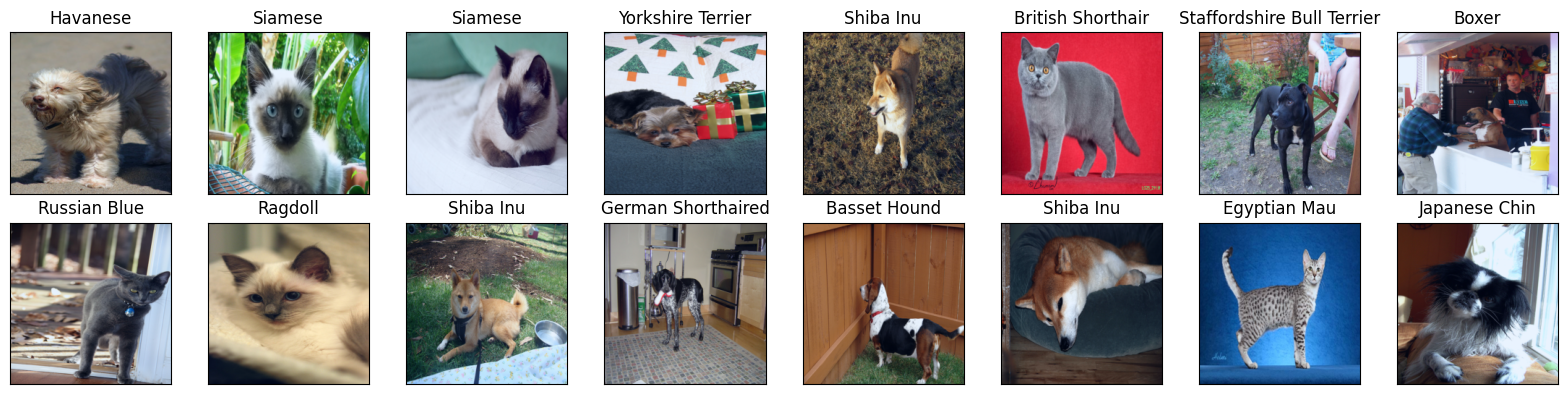

In [18]:
# Showing sample pets images
for x_batch, y_batch in train_dataloader:
    break  # Only get data from the 1st batch for now

fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_ = x_batch[i].permute(1, 2, 0) # restoring dimensions order
    img_ -= img_.min().item()  # normalizing image to 0..1
    img_ /= img_.max().item()
    ax.imshow(img_)
    label = train_dataset.classes[y_batch[i]]
    ax.set_title(f"{label}")
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
plt.tight_layout()

Remember that Imagenet includes quite a few cat and dog breeds among its classes.

Let's try to predcit breeds with Imagenet-pretrained model without finetuning first

In [19]:
# Predicting breeds with Imagenet-pretrained model
Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)  # tensor with class probabilities
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 1000]))

In [20]:
# Output top 3 predictions for each class using pretrained CNN (no finetuning)
# Expect to see high accuracy (70-80%) in some classes, much lower overal, mismatch in label spaces.

results_list = {}

for i, cl in enumerate(test_dataset.classes):
    class_stats = {"true_label":cl}
    probs1 = Y_probs[np.where(Y_true == i)].mean(axis=0).numpy()
    top_ix = probs1.argsort()[-1:][::-1]
    class_stats
    for j, l in enumerate(top_ix):
        class_stats = {f"pred_1": imagenet_labels[l],
                    f"prob_{1}": probs1.ravel()[l]}
    results_list[cl] = class_stats

df = pd.DataFrame(results_list).T.sort_values('prob_1', ascending=False)
float_cols = ['prob_1']
df.style.format('{:.2%}', subset=float_cols)

,pred_1,prob_1
Siamese,Siamese_cat,94.51%
Keeshond,keeshond,94.35%
Saint Bernard,Saint_Bernard,90.23%
Persian,Persian_cat,87.12%
Pomeranian,Pomeranian,85.34%
Pug,pug,84.19%
Samoyed,Samoyed,82.18%
Boxer,boxer,82.16%
Egyptian Mau,Egyptian_cat,82.02%
Leonberger,Leonberg,82.00%


### Finetuning CNN: classification layer only:

__Task 2: (3 points)__:<br>
Complete the code below and reach at least 85% accuracy by training only the classification layer:

In [10]:
classes_all = set(train_dataset.classes + test_dataset.classes)
classes_dict = {name: i for i, name in enumerate(classes_all)}
classes_id = list(range(0,len(classes_all)))
print(classes_all)

{'Siamese', 'Japanese Chin', 'German Shorthaired', 'Samoyed', 'Leonberger', 'English Cocker Spaniel', 'Bombay', 'Pug', 'English Setter', 'Egyptian Mau', 'Birman', 'British Shorthair', 'American Bulldog', 'Great Pyrenees', 'Miniature Pinscher', 'Boxer', 'Russian Blue', 'Bengal', 'Pomeranian', 'Maine Coon', 'Chihuahua', 'Keeshond', 'Sphynx', 'Saint Bernard', 'Wheaten Terrier', 'Ragdoll', 'Havanese', 'Shiba Inu', 'Beagle', 'Newfoundland', 'Scottish Terrier', 'Persian', 'Yorkshire Terrier', 'Abyssinian', 'Staffordshire Bull Terrier', 'Basset Hound', 'American Pit Bull Terrier'}


In [42]:
from torch import nn
# your task:
# 1) freeze all model parameters
# 2) replace model.fc with a new linear layer that has the appropriate number of outputs

ft_model = deepcopy(model).to(device)

for param in ft_model.parameters():
    param.requires_grad = False

ft_model.fc = nn.Linear(model.fc.in_features, len(classes_all)).to(device)
ft_model.fc.requires_grad=True

#ft_model.fc = nn.Sequential(
#    nn.Linear(model.fc.in_features, 1024),
#    nn.ReLU(),
#    nn.Linear(1024, len(classes_all))
#)

In [43]:
assert all(not p.requires_grad for p in ft_model.parameters() if p not in set(ft_model.fc.parameters()))
assert ft_model.fc.out_features == len(train_dataset.classes)
assert ft_model.fc.weight.device.type == device, f"ft_model.fc must be on {device}"
assert ft_model.fc.weight.requires_grad

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.001)

In [44]:
#torch.optim.Adam(model.parameters())  # all parameters
#torch.optim.Adam(model.fc.parameters())  # only head parameters


# weird useless example: train all weights except conv1
#conv1_params = set(model.conv1.parameters())
#these_params = [param for param in model.parameters() if param not in conv1_params]
#torch.optim.Adam(these_params)

In [15]:
import torch.nn.functional as F
def compute_loss(model, X_batch: torch.Tensor, y_batch: torch.Tensor):
    assert type(X_batch) == torch.Tensor and type(y_batch) == torch.Tensor
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [46]:
# train the finetuning model in a standard training loop.

num_epochs = 10  # Adjust number of epochs if needed

opt = torch.optim.Adam(ft_model.fc.parameters(), lr=0.001)

history = defaultdict(list)
for epoch in range(num_epochs):
    start_time = time.time()

    ft_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # calculate model predictions, calculate loss, make optimizer step
        #y_pred = ft_model(x_batch)

        loss = compute_loss(ft_model, x_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"

    ft_model.eval()
    val_losses = []
    val_cnt, val_correct = 0, 0
    pbar = tqdm(test_dataloader, leave=False)

    for x_batch, y_batch in pbar:

        # get model predictions, measure loss, collect data for accuracy calc
        y_pred = ft_model(x_batch.to(device))
        loss = compute_loss(ft_model, x_batch, y_batch)

        val_losses.append(loss.item())
        val_cnt += y_batch.shape[0]
        val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    accuracy = val_correct / val_cnt
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

    if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        break
print(f"Best Accuracy = {max(history['accuracy']):.2%}")

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.70348  val_loss=0.75892  accuracy=82.56%  epoch_time=76.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.56885  val_loss=0.55626  accuracy=85.66%  epoch_time=72.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.39561  val_loss=0.49534  accuracy=84.87%  epoch_time=73.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.31172  val_loss=0.45431  accuracy=86.92%  epoch_time=72.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.26137  val_loss=0.44604  accuracy=86.70%  epoch_time=73.6s
Best Accuracy = 86.92%


In [50]:
# This part of finetuning alone should deliver at least 85% accuracy.
assert accuracy > 0.85

In [51]:
# Predicting breeds with finetuned model

Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)

Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

  0%|          | 0/58 [00:00<?, ?it/s]

(torch.Size([3669]), torch.Size([3669, 37]))

In [49]:
# Measure Top1 prediction accuracy for each class

results_list = {}
total, correct = 0, 0

for i, cl in enumerate(test_dataset.classes):
    class_preds = np.where(Y_true == i)
    probs1 = Y_probs[class_preds].mean(axis=0).numpy()
    acc1 = probs1[i]
    class_stats = {"true_label":cl, 'acc1': acc1}
    total += class_preds[0].shape[0]
    correct += class_preds[0].shape[0] * acc1
    results_list[cl] = acc1

df = pd.Series(results_list).to_frame('acc1').sort_values('acc1', ascending=False)
df.style.format('{:.2%}', subset=['acc1'])

,acc1
German Shorthaired,96.96%
Keeshond,93.16%
Samoyed,93.03%
Saint Bernard,92.34%
Shiba Inu,91.65%
Japanese Chin,91.13%
Yorkshire Terrier,90.61%
Leonberger,90.08%
Scottish Terrier,88.66%
English Cocker Spaniel,87.24%


### Finetuning CNN: now unfreeze and train all layers:

__task 3 (5 points)__: Based on the previous task, continue finetuning the model run by training all of its layers. Obtain at least 90% accuracy (macro average, as defined in the code).
To reach 90%, you will need to experiment with network and/or training code, start from using improvements from the list below:

Scoring:
- reaching 90% accuracy - __3 points__
- testing out all 4 of these improvements - __2 points__:
    - Hyperparameters optimization
    - Image augmentation
    - Pretrained model selection
    - Early stopping training at epoch with best metric and / or loading the weights of best epoch. [read about `state_dict`](https://pytorch.org/tutorials/beginner/saving_loading_models.html#what-is-a-state-dict)
    
(you may not necessarily get spectacular results right away. Experiment and describe your actions and findings in a brief report in this notebook.)
- scoring above 90% -- __+1 BONUS point__ for every 1% improvement in accuracy above 90%

__Guidelines__: to improve quality of the finetuned model we can now train all of its layers.
- do this after initial training of classification layer
- set learning rate to much lower level to avoid explosion
- make all layers trainable using `requires_grad` param

#### my_model

In [90]:
from torch import nn

my_model = deepcopy(model).to(device)

for param in my_model.parameters():
    param.requires_grad = False

my_model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(),
    nn.Linear(256, len(classes_all))).to(device)
my_model.fc.requires_grad=True

assert all(not p.requires_grad for p in my_model.parameters() if p not in set(my_model.fc.parameters()))

my_opt = torch.optim.Adam(my_model.fc.parameters(), lr=0.001)

In [13]:
# train the finetuning model in a standard training loop.
def train_model(ft_model, opt,  train_dataloader, test_dataloader, num_epochs=10):

    history = defaultdict(list)
    for epoch in range(num_epochs):
        start_time = time.time()

        ft_model.train(True)
        ft_model.train()
        train_losses = []
        pbar = tqdm(train_dataloader, leave=False)
        for x_batch, y_batch in pbar:

            # calculate model predictions, calculate loss, make optimizer step
            #y_pred = ft_model(x_batch)

            loss = compute_loss(ft_model, x_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_losses.append(loss.item())
            pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"

        ft_model.train(False)
        ft_model.eval()
        val_losses = []
        val_cnt, val_correct = 0, 0
        pbar = tqdm(test_dataloader, leave=False)

        for x_batch, y_batch in pbar:

            # get model predictions, measure loss, collect data for accuracy calc
            y_pred = ft_model(x_batch.to(device))
            loss = compute_loss(ft_model, x_batch, y_batch)

            val_losses.append(loss.item())
            val_cnt += y_batch.shape[0]
            val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
            pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        accuracy = val_correct / val_cnt
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)
        print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")

        #if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        #   break
    print(f"Best Accuracy = {max(history['accuracy']):.2%}")

In [93]:
train_model(my_model, my_opt, train_dataloader, test_dataloader)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.87648  val_loss=0.77549  accuracy=81.85%  epoch_time=82.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.58674  val_loss=0.54633  accuracy=83.35%  epoch_time=84.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.40002  val_loss=0.46456  accuracy=85.47%  epoch_time=76.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.31676  val_loss=0.46245  accuracy=84.87%  epoch_time=76.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.27896  val_loss=0.48213  accuracy=85.15%  epoch_time=74.3s


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Now let’s further train the entire model by completely unlocking all parameters

In [95]:
# Continue training with all layers involved
for param in my_model.parameters():
    param.requires_grad = True

assert all (p.requires_grad for p in my_model.parameters())
my_all_opt = torch.optim.Adam(my_model.parameters(), lr=0.00005)  # reduce LR to avoid explosion

In [96]:
train_model(my_model, my_all_opt, train_dataloader, test_dataloader)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=0.19984  val_loss=0.36800  accuracy=88.01%  epoch_time=79.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.04927  val_loss=0.36153  accuracy=88.66%  epoch_time=80.1s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.02538  val_loss=0.35744  accuracy=88.63%  epoch_time=79.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.01663  val_loss=0.35289  accuracy=88.99%  epoch_time=78.8s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.01116  val_loss=0.35234  accuracy=89.26%  epoch_time=79.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.00827  val_loss=0.35150  accuracy=89.21%  epoch_time=79.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 6: train_loss=0.00656  val_loss=0.35331  accuracy=89.40%  epoch_time=80.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 7: train_loss=0.00546  val_loss=0.35459  accuracy=89.40%  epoch_time=80.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 8: train_loss=0.00418  val_loss=0.35373  accuracy=89.40%  epoch_time=79.2s


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Full additional training allowed us to achieve an accuracy of 89.4, which is about 3 percent more than just additional training of the head

#### Try fintune head again

Redefining the head with another FC structure and new additional training did not produce results. Accuracy did not exceed 89

#### Another pretrained model

Let's try to change the pre-trained version of the neural network, it may be possible to improve the result

In [20]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet34, ResNet34_Weights
device = 'cuda'
model = resnet34(weights=ResNet34_Weights.DEFAULT) # load model with best available weights
model.train(False);        # set the model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 86.3MB/s]


In [21]:
from torch import nn

my_model = deepcopy(model).to(device)

for param in my_model.parameters():
    param.requires_grad = False

my_model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Linear(512, len(classes_all))).to(device)
my_model.fc.requires_grad=True

assert all(not p.requires_grad for p in my_model.parameters() if p not in set(my_model.fc.parameters()))

my_opt = torch.optim.Adam(my_model.fc.parameters(), lr=0.001)

In [22]:
train_model(my_model, my_opt, train_dataloader, test_dataloader)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.44793  val_loss=0.52599  accuracy=84.82%  epoch_time=83.5s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.38582  val_loss=0.39060  accuracy=88.14%  epoch_time=79.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.27251  val_loss=0.37100  accuracy=87.46%  epoch_time=78.7s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.20771  val_loss=0.38032  accuracy=86.92%  epoch_time=78.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.18292  val_loss=0.39187  accuracy=86.84%  epoch_time=78.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Now let’s train the neural network completely again

In [23]:
# Continue training with all layers involved
for param in my_model.parameters():
    param.requires_grad = True

assert all (p.requires_grad for p in my_model.parameters())
my_all_opt = torch.optim.Adam(my_model.parameters(), lr=0.00002)  # reduce LR to avoid explosion

In [24]:
train_model(my_model, my_all_opt, train_dataloader, test_dataloader)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=0.10501  val_loss=0.31415  accuracy=89.94%  epoch_time=95.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.02867  val_loss=0.30669  accuracy=90.71%  epoch_time=93.2s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.01623  val_loss=0.30437  accuracy=90.71%  epoch_time=98.9s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.01036  val_loss=0.30378  accuracy=90.95%  epoch_time=93.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.00836  val_loss=0.30490  accuracy=90.90%  epoch_time=91.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 5: train_loss=0.00619  val_loss=0.30657  accuracy=90.90%  epoch_time=94.6s


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Using a more powerful version of reznet for additional training, we were able to increase the accuracy of our model to 90.

If we take reznet50 as a basis, then we don’t even need to retrain the entire network. So only with head training, we will reach 90%

In [25]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet50, ResNet50_Weights
device = 'cuda'
model = resnet50(weights=ResNet50_Weights.DEFAULT) # load model with best available weights
model.train(False);        # set the model to evaluation mode

In [26]:
from torch import nn

my_model = deepcopy(model).to(device)

for param in my_model.parameters():
    param.requires_grad = False

my_model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1024),
    nn.ReLU(),
    nn.Linear(1024, len(classes_all))).to(device)
my_model.fc.requires_grad=True

assert all(not p.requires_grad for p in my_model.parameters() if p not in set(my_model.fc.parameters()))

my_opt = torch.optim.Adam(my_model.fc.parameters(), lr=0.001)

In [27]:
train_model(my_model, my_opt, train_dataloader, test_dataloader)

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 0: train_loss=1.12109  val_loss=0.41093  accuracy=87.11%  epoch_time=101.3s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 1: train_loss=0.18693  val_loss=0.33838  accuracy=88.85%  epoch_time=100.4s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 2: train_loss=0.09499  val_loss=0.30726  accuracy=89.78%  epoch_time=96.0s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 3: train_loss=0.05154  val_loss=0.29174  accuracy=90.90%  epoch_time=94.6s


  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

Ep. 4: train_loss=0.02770  val_loss=0.31821  accuracy=90.49%  epoch_time=102.8s


  0%|          | 0/58 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

But I cant do next step: "retrain all NN", cause exception Cuda Out Of Memory wich i cant solve

In [30]:
# Continue training with all layers involved
for param in my_model.parameters():
    param.requires_grad = True

assert all (p.requires_grad for p in my_model.parameters())
my_all_opt = torch.optim.Adam(my_model.parameters(), lr=0.00001)  # reduce LR to avoid explosion

In [31]:
train_model(my_model, my_all_opt, train_dataloader, test_dataloader)

  0%|          | 0/58 [00:00<?, ?it/s]

OutOfMemoryError: ignored

# STUDENT'S REPORT

Please write a short report describing the steps you took to improve quality. It should be at least a short paragraph with 3-5 sentences and, optionally, any relevant numbers/charts, but there's no upper limit.

Here's what i did: <YOUR TEXT>

As a result, we were able to achieve an accuracy of 90 percent. In general, the main pipeline for building a model looks like this: we take a pre-trained model, fix the body of the non-network, and change its head to a configuration that suits our task. We train the head layer on the data, obtaining good accuracy. In the future, we will activate all the primary parameters and with a small learning coefficient, so as not to overtrain our model, we will improve our accuracy, since we will further optimize all convolution layers. This way we get the desired model. To get an even better result, we can add augmentation to our images, expand the dataset with classes that are most difficult to detect/are in the minority.
There is also the idea of first detecting the class of a dog or a cat and then, depending on the prediction, sending it to the 2nd model, which is focused purely on determining the breeds of this class.

# Bonus task __(optional. 2 more points)__:

Notice that accuracy varies across breeds. Build confusion Propose improvements to the model finetuning process to improve minimal accuracy levels for all classes. Show the model runs.
Measure the improvement in terms of minimal accuracy and micro-averaged accuracy.

# EXTRA STUFF:


## Links:    
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
- [Activations Atlas](https://distill.pub/2019/activation-atlas/)
- more models from https://github.com/huggingface/pytorch-image-models
- Papers with code: benchmarks and model references. https://paperswithcode.com/sota/image-classification-on-imagenet